<a href="https://colab.research.google.com/github/EA-park/AIFFEL/blob/main/%5BExp_03%5DMy_First_Kaggle_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

루브릭

1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?   
 - 작성한 노트북을 캐글에 제출했다.

2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?
 - 제출한 주피터노트북 파일이 캐글 커널 환경에서도 에러 없이 동작하며, 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.

3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?
 - 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110,000 이하의 점수를 얻었다.

#2019 ML month 2nd baseline 커널

Public score: 109710.39971      
Private Score: 118464.57654

## 전처리

In [151]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import sys

import scipy as sp
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. 데이터 살펴보기

###변수 설명

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

###데이터 크기 확인

In [156]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
print(f'train data dim : {train.shape}')
print(f'test data dim : {test.shape}')

train data dim : (15035, 21)
test data dim : (6468, 20)


###목적변수와의 상관관계 확인

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


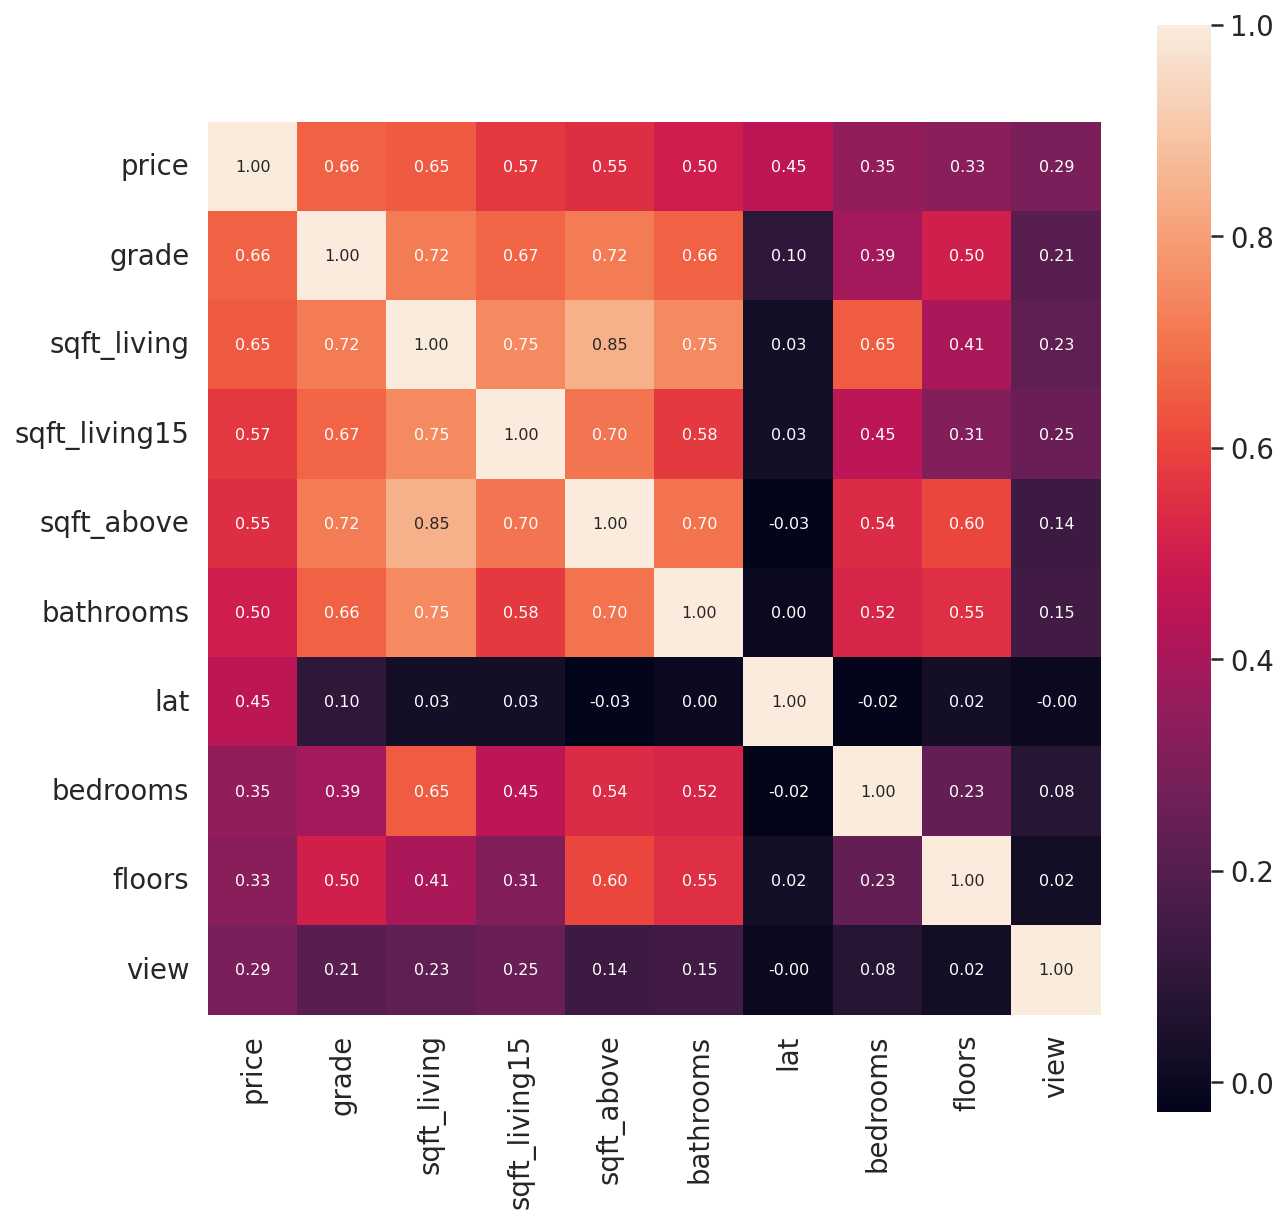

In [157]:
cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='price').index
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0]
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True, annot_kws={'size' : 8}, xticklabels=cor_cols.values, yticklabels=cor_cols.values)
plt.show()

## 2. 간단한 전처리

###훈련 데이터와 테스트 데이터 합치기


In [158]:
y = train['price']
del train['price']
print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [159]:
train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 결측치 확인
1. 그래프 사용

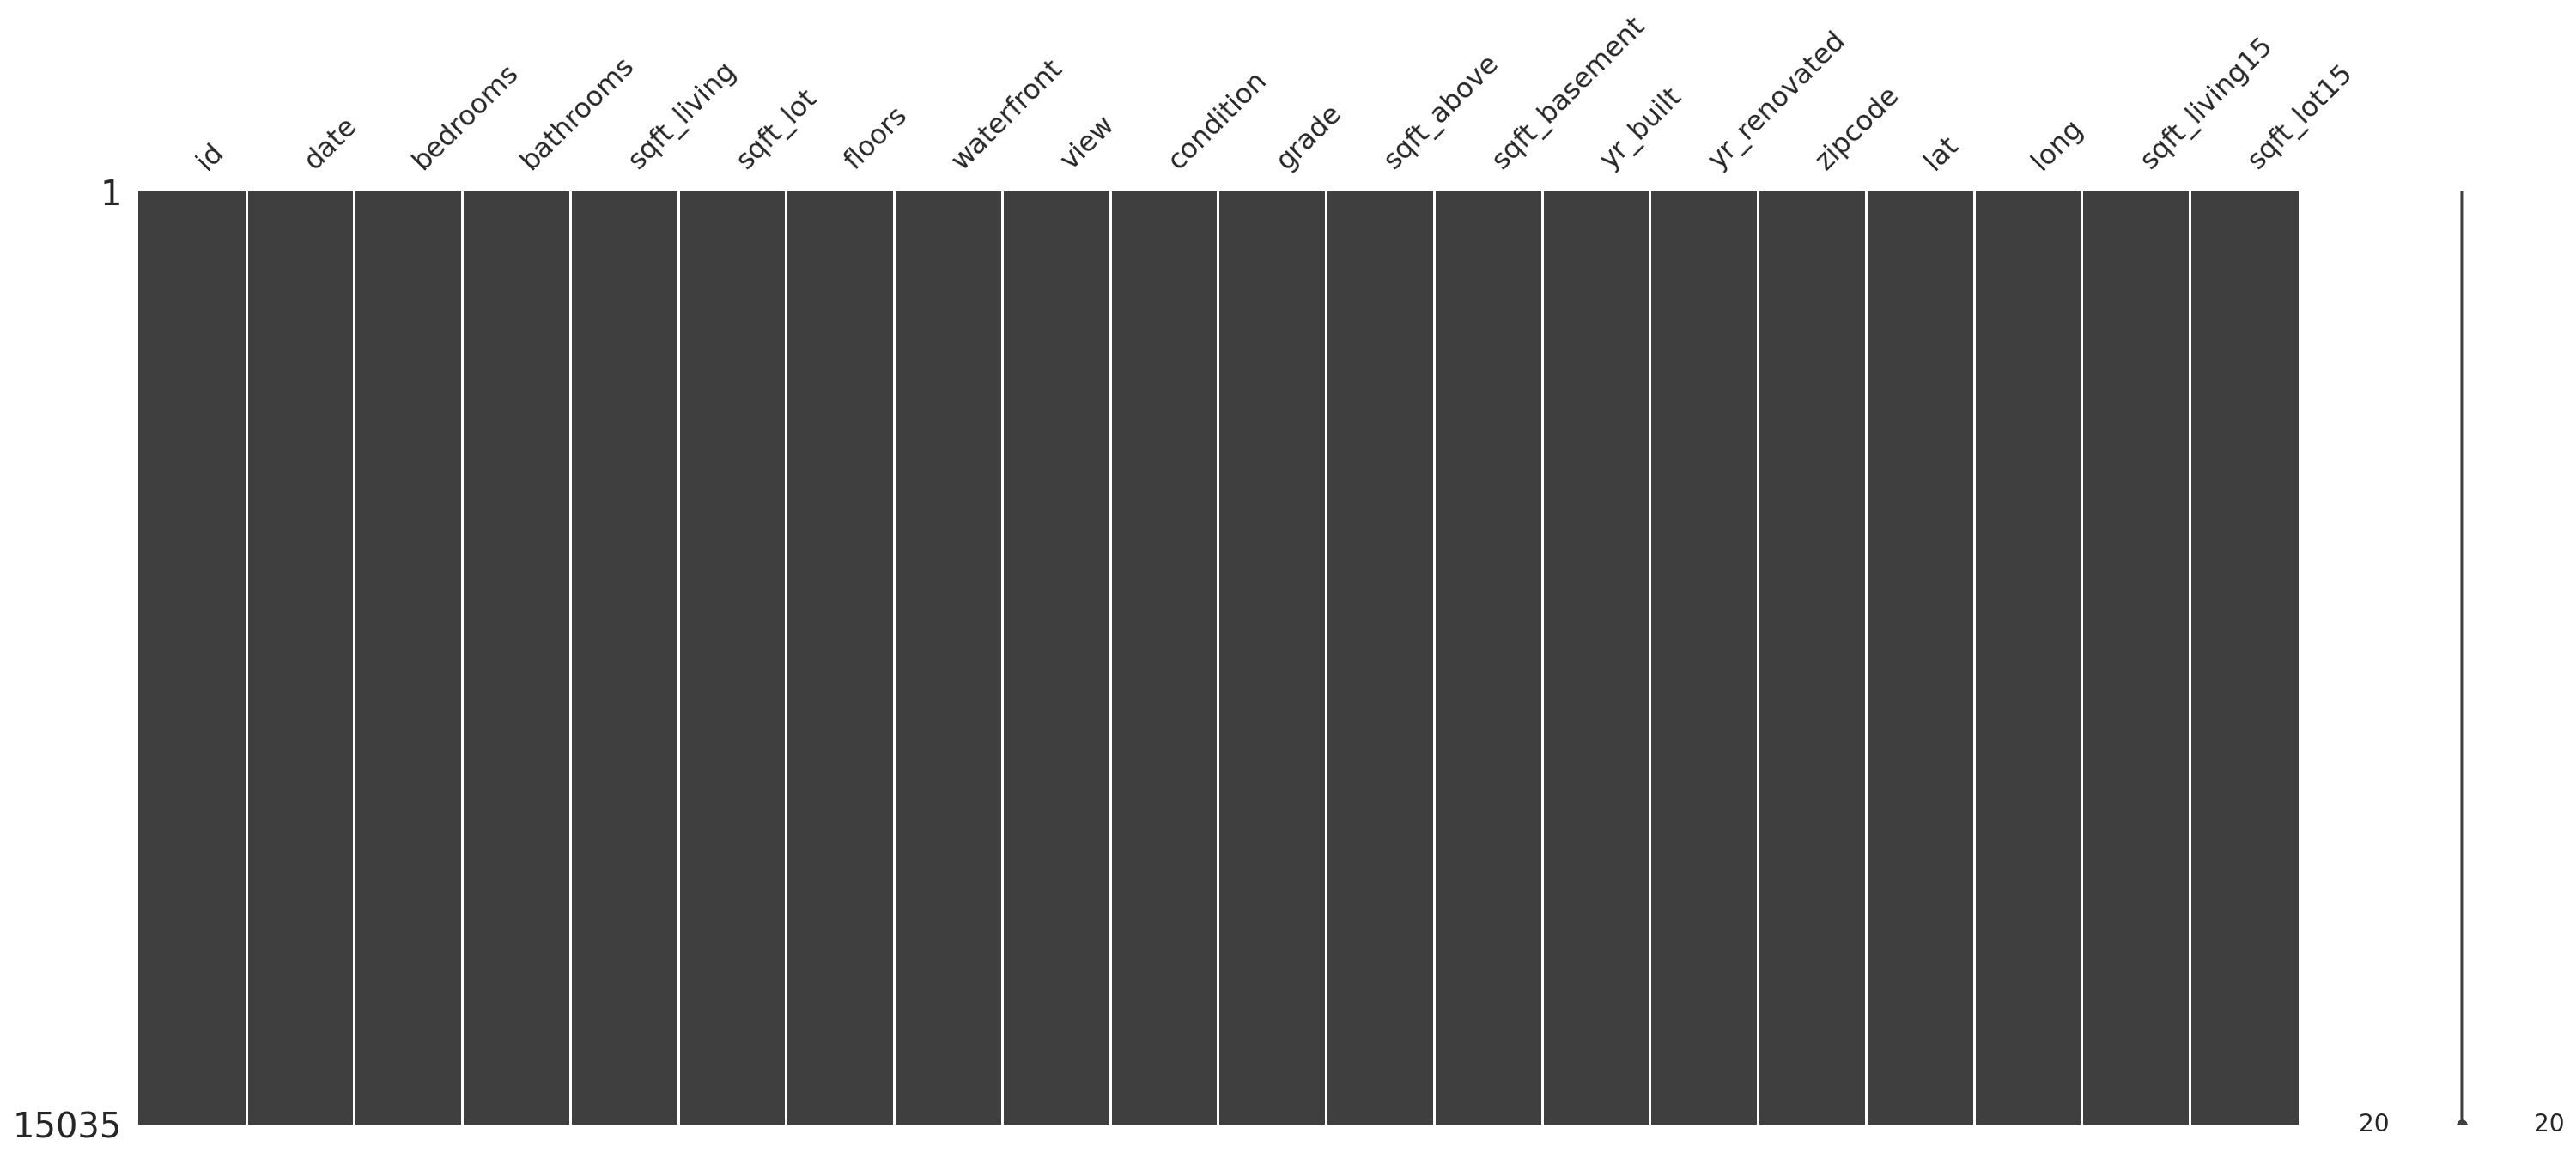

In [160]:
msno.matrix(train)

2. isnull 사용

In [161]:
for c in train.columns:
    print(f'{c} : {len(train.loc[pd.isnull(train[c]), c].values)}') #df.loc[행조건, 열조건]

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [162]:
for c in test.columns:
    print(f'{c} : {len(test.loc[pd.isnull(test[c]), c].values)}') #df.loc[행조건, 열조건]

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
- id 변수 : 삭제<br>
- date 변수 : int 변환

In [163]:
sub_id = test['id']
del train['id']
del test['id']
train['date'] = train['date'].apply(lambda x : str(x[:6])).astype(int)
test['date'] = test['date'].apply(lambda x : str(x[:6])).astype(int)

In [164]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [165]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [166]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           6468 non-null   int64  
 1   bedrooms       6468 non-null   int64  
 2   bathrooms      6468 non-null   float64
 3   sqft_living    6468 non-null   int64  
 4   sqft_lot       6468 non-null   int64  
 5   floors         6468 non-null   float64
 6   waterfront     6468 non-null   int64  
 7   view           6468 non-null   int64  
 8   condition      6468 non-null   int64  
 9   grade          6468 non-null   int64  
 10  sqft_above     6468 non-null   int64  
 11  sqft_basement  6468 non-null   int64  
 12  yr_built       6468 non-null   int64  
 13  yr_renovated   6468 non-null   int64  
 14  zipcode        6468 non-null   int64  
 15  lat            6468 non-null   float64
 16  long           6468 non-null   float64
 17  sqft_living15  6468 non-null   int64  
 18  sqft_lot

### 각 변수들의 분포 확인
한쪽으로 치우친 분포 수정

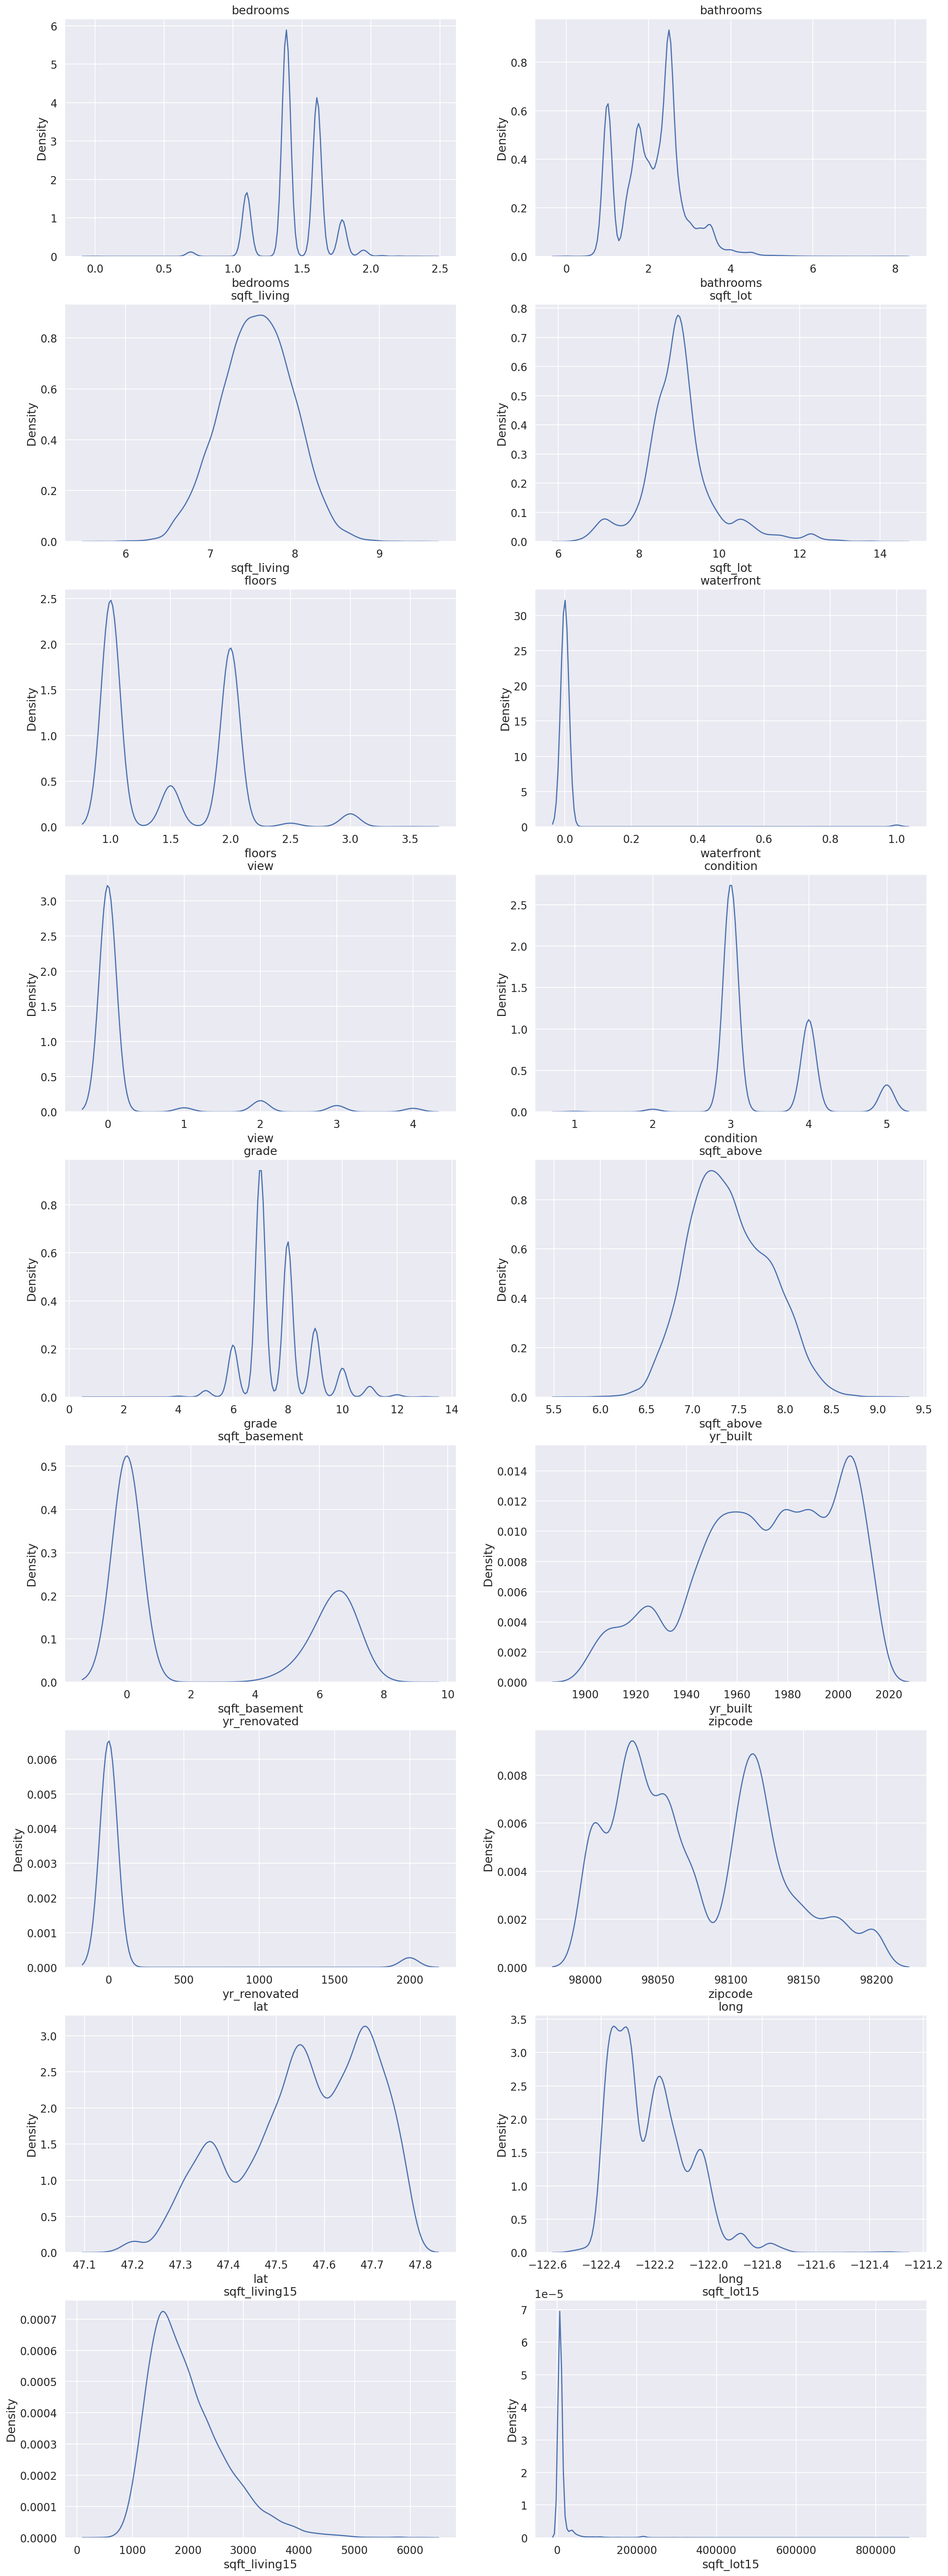

In [222]:
fig, ax = plt.subplots(9, 2, figsize=(20, 60))

# id 변수(count=0)는 제외하고 분포 확인
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

In [168]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

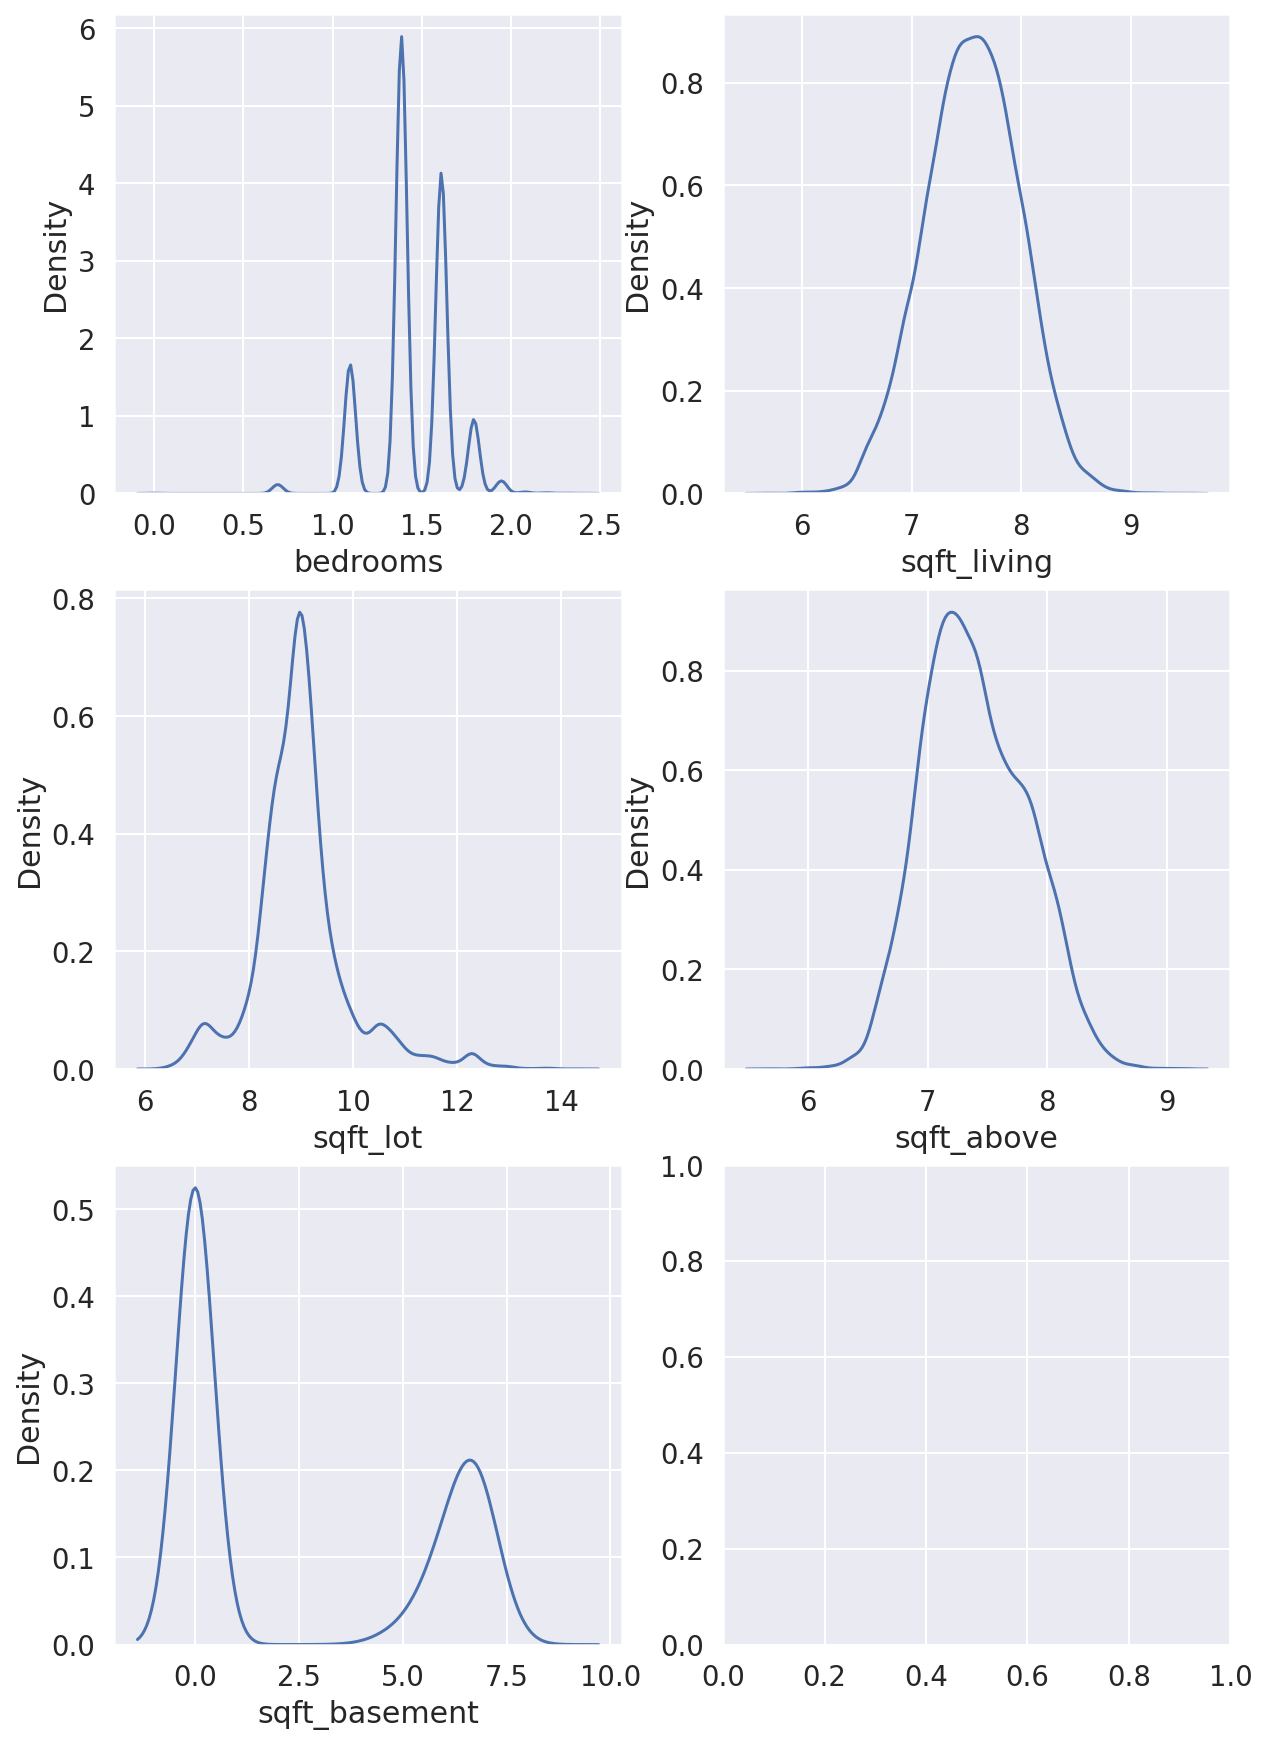

In [169]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col])
        count+=1

모델 파라미터 skewness 확인

In [ ]:
sns.kdeplot(y)
plt.show()

In [170]:
y = np.log1p(y)

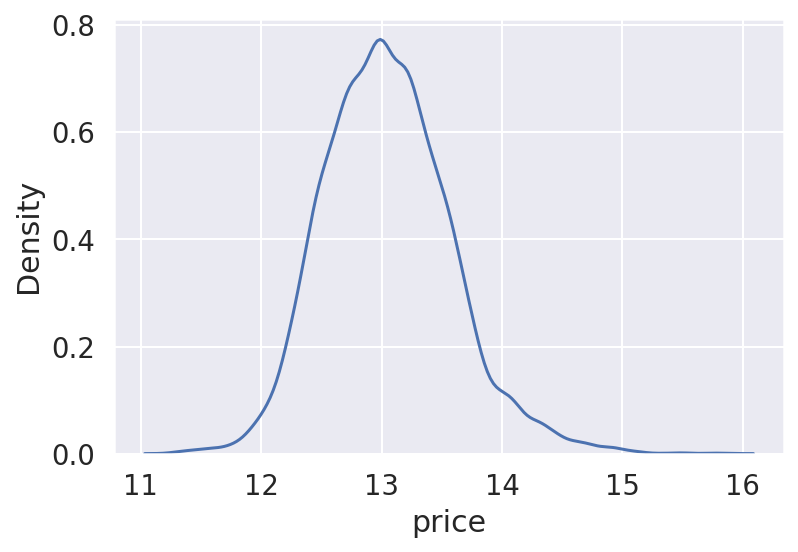

In [171]:
sns.kdeplot(y)
plt.show()

## 3. 모델링


In [243]:
random_state = 54

###Hyperparameter
Grid search 방법

In [198]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [204]:
param_grid = {'learning_rate': [0.001, 0.1], 'n_estimators': [10, 500]}
model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,learning_rate,n_estimators,score,RMSLE
3,0.100,500,-0.027538,0.165947
2,0.100,10,-0.099514,0.315458
1,0.001,500,-0.156435,0.395518
0,0.001,10,-0.274897,0.524306


In [209]:
param_grid = {'n_estimators': [50, 100], 'max_depth': [1, 10]}
model = xgb.XGBRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[16:04:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027048,0.164464
2,10,50,-0.034187,0.184897
1,1,100,-0.054988,0.234496
0,1,50,-0.077518,0.278421


In [240]:
param_grid = {'n_estimators': [50, 100], 'max_depth': [1, 10]}
model = lgb.LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.043334,0.208167
2,10,50,-0.043636,0.208893
1,1,100,-0.055934,0.236503
0,1,50,-0.073359,0.270849


### Average Blending
산술 평균을 이용한 Blending 모델

In [246]:
gboost = GradientBoostingRegressor(learning_rate=0.1, n_estimators=500, random_state=random_state)
xgboost = xgb.XGBRegressor(max_depth=10, n_estimators=100, random_state=random_state)
lightgbm = lgb.LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
모델의 성능 평가

1) 산술평균

In [247]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=train.values, y=y, cv=kfold))
        print(f"Model {m['name']} CV score : {CV_score:.4f}")

In [248]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8394
[18:01:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:01:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:01:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:01:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:01:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model XGBoost CV score : 0.8401
Model LightGBM CV score : 0.8439


2) RMSE

In [215]:
from sklearn.metrics import mean_squared_error
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [216]:
def get_scores(models, train, y):
    df = {}
    
    for m in models:
        model_name = m['model'].__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=100)
        m['model'].fit(X_train, y_train)
        y_pred = m['model'].predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [253]:
score_df = get_scores(models, train, y)
score_df

[18:02:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
XGBRegressor,187343.719911
LGBMRegressor,167078.829483
GradientBoostingRegressor,165946.883802


### Make Submission

모델 학습

In [249]:
def MaxBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.max(predictions, axis=1)

In [250]:
y_pred = MaxBlending(models, train, y, test)

[18:02:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [251]:
#np.set_printoptions(threshold=10)  # 생략 제거 : sys.maxsize
y_pred = np.expm1(y_pred)
print(y_pred)

[ 522238.78028213  360652.51127197 1924934.66845285 ...  431681.54492253
  340086.97710059  437712.33643478]


##캐글 제출
###결과 파일 확인

In [181]:
submission = pd.read_csv('../input/sample_submission.csv')
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


id와 price로 구성된 데이터 프레임 생성

In [252]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.222388e+05
1,15036,3.606525e+05
2,15037,1.924935e+06
3,15038,3.292309e+05
4,15039,3.048967e+05


submission.csv 파일 저장

In [ ]:
result.to_csv("submission.csv",index=False)

#회고

###1. 이번 프로젝트에서 어려웠던 점
- 각 단계별로 처음 해보는 작업이라 다 어려웠음     
  (새로운 전처리 방법, 캐글에 데이터를 제출하는 것, model blending, hyperparameter optimization)

###2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
1) 알아낸 점   
- 캐글에 제출된 코드 확인하는 방법
- 캐글 커널의 전반적인 순서    
 (전처리 -> 모델 선정 -> hyperparameter optimization -> model blending -> 제출 형식 맞추기)

2) 아직 모호한 점
- 모델 선정 방법 또는 기준
- random_state를 동일하게 해서 실행했는데, cv_score가 달라진 이유

###3. 루브릭 평가 지표를 맞추기 위해 시도한 것들
- Exploration 노드 3-9 ~ 3-12 반복 학습
- Exploration 노드에 나오지 않은 hyperparameter을 검색하여 최적화



###4. 다짐
- 캐글 노트북을 참조해서 EDA, hyperparameter optimization, staking ensemble을 학습해야 겠다.